In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random

from sklearn.model_selection import train_test_split

**Context**

Kaggle dataset lien https://www.kaggle.com/birdy654/scene-classification-images-and-audio

In [25]:
data = pd.read_csv('data/dataset.csv', delimiter=',', nrows=None)
data_train = np.array(data)

audio = data_train[:,1:-2].astype('float32') #last index of the interval isn't included in the range : CLASS1
labels = data_train[:,-1]
img_paths = data['IMAGE']

img_train, img_temp, audio_train, audio_temp, labels_train, labels_temp = train_test_split(img_paths, audio, labels, train_size=0.6)
img_val, img_test, audio_val, audio_test, labels_val, labels_test = train_test_split(img_temp, audio_temp, labels_temp, train_size=0.5)

print(np.shape(audio_train))
print(np.shape(audio_val))
print(np.shape(audio_test))
data.head(10)


(10351, 104)
(3450, 104)
(3451, 104)


,IMAGE,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_97,mfcc_98,mfcc_99,mfcc_100,mfcc_101,mfcc_102,mfcc_103,mfcc_104,CLASS1,CLASS2
0,images/forest/forest0.png,15.795384,-3.442518,-25.316836,-33.412104,2.447290,-46.981182,12.889984,-23.588534,-22.625879,...,-43.876462,20.697491,-22.793173,-9.417196,13.762870,-31.976786,18.461561,-13.140673,OUTDOORS,FOREST
1,images/forest/forest1.png,15.883880,-3.494075,-21.189490,-18.077115,4.284962,-27.014271,3.666955,-9.091312,-3.746509,...,-33.883092,17.223236,-24.985005,12.035913,8.321000,-16.249293,8.717523,0.743640,OUTDOORS,FOREST
2,images/forest/forest2.png,17.872629,-18.877467,-31.665319,-47.045579,1.813430,-45.899877,14.975982,-24.462396,-1.812962,...,-34.456028,21.433239,-14.190274,-8.629235,1.035640,-20.703358,5.986662,-14.644013,OUTDOORS,FOREST
3,images/forest/forest3.png,16.843997,-3.527753,-21.282970,-24.248141,27.201589,-18.787674,30.093938,-1.922008,10.156418,...,-36.410615,19.949251,-5.466172,6.480569,13.070739,-14.853299,10.243606,-17.983957,OUTDOORS,FOREST
4,images/forest/forest4.png,16.128583,-4.267328,-25.608325,-20.231084,15.922823,-35.703313,16.307644,-3.547505,4.804142,...,-41.548915,15.697646,-20.615005,-11.942869,5.421639,-27.445147,9.060233,-15.077528,OUTDOORS,FOREST
5,images/forest/forest5.png,21.689841,-15.971450,-26.837817,-46.561006,20.770073,-8.153000,16.801556,-4.589764,7.219863,...,-21.613514,42.223289,-11.695203,2.910106,-35.891702,-2.755247,-2.448610,13.279929,OUTDOORS,FOREST
6,images/forest/forest6.png,16.123850,-0.502807,-31.532553,-26.753161,22.110188,-44.973076,35.949924,-20.104215,-12.638088,...,-53.407842,32.373979,-28.167140,-7.078691,5.199906,-50.789380,5.619568,-30.189872,OUTDOORS,FOREST
7,images/forest/forest7.png,15.871565,-0.763786,-24.201742,-24.479100,12.975591,-41.588451,26.818111,-6.913483,-4.095325,...,-37.867910,33.380044,-22.327289,-11.202320,-10.254014,-26.236774,4.476926,-4.142449,OUTDOORS,FOREST
8,images/forest/forest8.png,17.764418,-4.284194,-27.631842,-49.291224,12.780080,-43.668120,34.199202,-25.522677,10.561731,...,-39.800392,7.948283,-31.925772,8.836070,-18.177841,-10.745605,-16.128549,5.578362,OUTDOORS,FOREST
9,images/forest/forest9.png,17.008391,-7.689599,-23.670928,-35.503255,16.394963,-54.073955,22.142703,-24.226244,0.829439,...,-40.544998,13.595717,-19.715312,-8.342403,-14.912854,-24.710224,9.749967,-10.477606,OUTDOORS,FOREST


On définit les seeds qui permettent de générer aléatoirement les mêmes nombres, et donc rendre les résultats reproductibles.

In [26]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)
np.random.seed(0)

**Pytorch Dataset**

On créé une classe Dataset

In [27]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data_type, root_dir, img_data, audio_data, labels=None, img_transform=None, audio_transform=None):
        self.root_dir = root_dir
        self.img_data = img_data
        self.audio_data = audio_data
        self.labels = labels
        self.img_transform = img_transform
        self.audio_transform = audio_transform
        self.data_type = data_type
        
    def __len__(self):
        return len(self.img_data)
        
    def __getitem__(self, idx):
        if self.data_type == "img":
            img = os.path.join(self.root_dir, self.img_data.iloc[idx])
            if self.img_transform:
                img = self.img_transform(img)
            audio = None
            
        elif self.data_type == "audio":
            audio = self.audio_data[idx,:]
            if self.audio_transform:
                audio = self.audio_transform(audio)
            img = None
        
        elif self.data_type == "imgaudio":
            img = os.path.join(self.root_dir, self.img_paths.iloc[idx])
            audio = self.audio_data[idx,:]
            if self.img_transform:
                img = self.img_transform(img)
                audio = self.audio_transform(audio)

        else:
            raise ValueError('Data must be img, audio or imgaudio')
                               
        return ( data_type, img, audio if labels is None else  data_type, img, audio, self.labels[idx])

**BASELINE**

In [28]:
"""from random import seed
from random import randrange

def zero_rule_algorithm_classification(train, test):
    output_values = [row[-1] for row in train]
    prediction = max(set(output_values), key=output_values.count)
    predicted = [prediction for i in range(len(test))]
    return predicted

seed(1)

predictions = zero_rule_algorithm_classification(data_train, data_train)
#print(predictions)"""

"""
train
predict

data augmentation
load data imag
get imagenet pretrained model --> compare feature extraction and transfer learning 2 last layers
use train
use predict
"""

'\ntrain\npredict\n\ndata augmentation\nload data imag\nget imagenet pretrained model --> compare feature extraction and transfer learning 2 last layers\nuse train\nuse predict\n'

**TRAIN**

In [29]:
def train(train_loader, val_loader, model, criterion, optimizer, scheduler, epochs=20):
    
    print("trainloader :", train_loader[0], "\nval_loader :",  val_loader[0])
    
    for epoch in range(epochs):
        for index, data in enumerate(train_loader):
            data_type, img, audio, labels = data
            img, audio, labels = img.cuda(), audio.cuda(), labels.cuda()
            
            optimizer.zero_grad()
          
        #We compute validation data accuracy on each epoch to prevent overfitting 
        #if val_accuracy isn't improved by current training epoch
        val_acc = 0
        model.eval()
        with torch.no_grad: #Validation data aim to test, not to train NN --> grad isn't needed
            for dat_type, img, audio, imgaudio, labl in val_loader:
                img, audio, labels = img.cuda(), audio.cuda(), labels.cuda()
                if data_type == "img":
                    outputs = model(img)
                elif data_type == "audio":
                    outputs = model(audio)
                else:
                    outputs = model(img, audio)
    return None

**PREDICT**

In [30]:
def predict():
    return None

**<font size="6" color="darkblue">IMAGES</font>**

Explication données image

**IMAGE VISUALIZATION**

**DATA TRANSFORMATION** 

In [31]:
from torchvision import transforms

# DA : Data Augmentation
# DP : Data Preparation --> transform data to a more ergonomic data format

img_train_transform = transforms.Compose([ #Compose is used to chain multiple transforms to create a transformation pipeline
    transforms.RandomResizedCrop(224), #DA
    transforms.RandomHorizontalFlip(), #DA
    transforms.ToTensor(), #DP to compute on GPU
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #DP
])
img_val_transform = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    transforms.Resize(256), #DA fixed resize and crop for reliability
    transforms.CenterCrop(224),# DA
    transforms.ToTensor(), #DP
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #DP
])

**IMAGE LOADER**

In [32]:
from torch.utils.data import Dataset, DataLoader

data_type = 'img'
train_data = CustomDataset(data_type=data_type, root_dir='/data', img_data=img_train, audio_data=audio_train, labels=labels_train, img_transform=img_train_transform)
val_data = CustomDataset(data_type=data_type, root_dir='/data', img_data=img_val,  audio_data=audio_val,labels=labels_val, img_transform=img_val_transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

**TRANSFER LEARNING** 

on charge le réseau préentrainé
On utilise Imagenet

In [33]:
import torchvision.models
import torch
import torch.nn as nn
import torch.nn.functional as F

resnext = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)

for param in resnext.parameters():
    param.requires_grad = False
    
num_ftrs = resnext.fc.in_features
resnext.fc = nn.Linear(num_ftrs, 9)

resnext = resnext.cuda()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [40]:
from torch.optim import lr_scheduler
import torch.optim as optim

optimizer = optim.Adam(resnext.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=0,factor=0.5)

In [39]:
import matplotlib.pyplot as plt

epochs = 30
resnext, loss_vals, train_acc_vals, val_acc_vals = train(resnext, train_loader, val_loader, criterion, optimizer, scheduler, epochs)

TypeError: 'ResNet' object does not support indexing

**<font size="6" color="darkblue">AUDIO</font>**

Type de données MCCF

**AUDIO DATA VISUALIZATION**

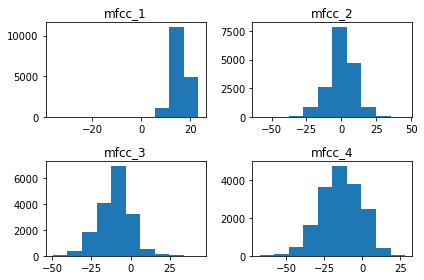

In [18]:
import matplotlib.pyplot as plt

plt.subplot(2,2,1)
plt.hist(audio[::,0])
plt.title('mfcc_1')
plt.subplot(2,2,2)
plt.hist(audio[::,1])
plt.title('mfcc_2')
plt.subplot(2,2,3)
plt.hist(audio[::,2])
plt.title('mfcc_3')
plt.subplot(2,2,4)
plt.hist(audio[::,3])
plt.title('mfcc_4')
plt.tight_layout()

In [43]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.linear1 = nn.Linear(104, 156)
        self.bn1 = nn.BatchNorm1d(156)
        
        self.linear2 = nn.Linear(156, 208)
        self.bn2 = nn.BatchNorm1d(208)
        
        self.linear3 = nn.Linear(208, 156)
        self.bn3 = nn.BatchNorm1d(156)
        
        self.linear4 = nn.Linear(156, 104)
        self.bn4 = nn.BatchNorm1d(104)
        
        self.linear5 = nn.Linear(104, 64)
        self.bn5 = nn.BatchNorm1d(64)


        self.final = nn.Linear(64,9)
      
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.linear1(x)))
        x = F.leaky_relu(self.bn2(self.linear2(x)))
        x = F.leaky_relu(self.bn3(self.linear3(x)))
        x = F.leaky_relu(self.bn4(self.linear4(x)))
        x = F.leaky_relu(self.bn5(self.linear5(x)))

        x = self.final(x)
        return x

mlp = MLP().cuda()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

**DATA PROCESSING METHODS**

In [16]:
def normalize(data):
    return (data - np.mean(data, axis=0))/np.std(data, axis=0)

audio_train = normalize(audio_train)
audio_val = normalize(audio_val)

In [20]:
class AddGaussianNoise:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [21]:
class RandomCircularShift:      
    def __call__(self, tensor):
        return torch.roll(tensor, 13*np.random.randint(8),dims=0)

**AUDIO DATA TRANSFORMATION** 

In [38]:
from torchvision import transforms

audio_train_transform = transforms.Compose([
    AddGaussianNoise(0.0, 0.1)
    RandomCircularShift()
])

audio_val_transform = transforms.Compose([
    AddGaussianNoise(0.0, 0.1)
    RandomCircularShift()
])

SyntaxError: invalid syntax (<ipython-input-38-5cc8d1f7d9fc>, line 5)

**AUDIO DATA LOADER**

In [14]:
data_type = 'audio'
train_data = CustomDataset(data_type=data_type, root_dir='/data', img_data=img_train, audio_data=audio_train, labels=labels_train, audio_transform=audio_train_transform)
val_data = CustomDataset(data_type=data_type, root_dir='/data', img_data=img_val, audio_data=audio_val, labels=labels_val, audio_transform=audio_val_transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

In [41]:
optimizer = optim.Adam(resnext.fc.parameters(), lr=0.001) 
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=0,factor=0.5)

In [42]:
epochs = 30
resnext, loss_vals, train_acc_vals, val_acc_vals = train(resnext, train_loader, val_loader, criterion, optimizer, scheduler, epochs)

TypeError: 'ResNet' object does not support indexing